In [1]:
#import data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

data1 = pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/plate_reader_assay/plate_reader_segregants_10_31.xlsx")
data2 = pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/plate_reader_assay/bence 11 05.xlsx")
data3 = pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/plate_reader_assay/bence 11 05 2.xlsx")
data4 = pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/plate_reader_assay/bence 11 05 3.xlsx")
data5 = pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/plate_reader_assay/bence 11 05 4.xlsx")
data1.drop(range(1056,1077), inplace=True)
data5.drop(range(1056,1077), inplace=True)

data_wi=pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/plate-reader-floc_wi/20221018_day1_wild_isolates.xlsx")
data_wi2=pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/plate-reader-floc_wi/20221018_day1_wild_isolates2.xlsx")
data_wi3=pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/plate-reader-floc_wi/bence wi emm 1.xlsx")
data_wi4=pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/plate-reader-floc_wi/bence wi emm 2.xlsx")
data_wi5=pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/plate-reader-floc_wi/bence wi emm 3.xlsx")
#remove the last 21 rows
data_wi.drop(range(len(data_wi)-21,len(data_wi)), inplace=True)
data_wi2.drop(range(len(data_wi2)-21,len(data_wi2)), inplace=True)
data_wi3.drop(range(1056,1077), inplace=True)
data_wi4.drop(range(1056,1077), inplace=True)
data_wi5.drop(range(1056,1077), inplace=True)


#wild isolate YES /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/apr 16/bence_wi_yes_1.xlsx
data_wi_yes_1 = pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/apr 16/bence_wi_yes_1.xlsx")
data_wi_yes_2 = pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/apr 16/bence_wi_yes_2.xlsx")
data_wi_yes_3 = pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/apr 16/bence_wi_yes_3.xlsx")
data_wi_yes_1.drop(range(1056,1077), inplace=True)
data_wi_yes_2.drop(range(1056,1077), inplace=True)
data_wi_yes_3.drop(range(1056,1077), inplace=True)

In [2]:
#the 0th 10th, 20th etc. rows have identifiers such as A1, and A2 till F12. In between is the data. Extract these identifiers, and attach their respective data as a list
def get_cv_df(data,control_loc,sqrt_n_scans_per_well_plus_one):
    identifiers = []
    data_list = []
    for i in range(0, len(data), sqrt_n_scans_per_well_plus_one): #sqrt_n_scans_per_well_plus_one is 11 for seg and wt, and sometimes 10
        identifiers.append(data.iloc[i, 0])
        data_list.append(data.iloc[i+1:i+sqrt_n_scans_per_well_plus_one])

    CVs = []
    #find the 38th entry in data_list.
    control = data_list[control_loc] #37 for seg, 82 for wi
    #replace entries with Unused to np.nan
    control = control.replace("Unused", np.nan)
    control = control.to_numpy().flatten()
    control = control[~np.isnan(control)]
    #take mean of control
    control_mean = np.mean(control)
    
    for i in data_list:
       
        #change entries with Unused to 0
        i = i.replace("Unused", np.nan)
        i = i.to_numpy().flatten()
        #remogve nan values
        i = i[~pd.isnull(i)]
        #if not float value then remove from i. Make a list comprehension and test for float
        i = [x for x in i if isinstance(x, float)]
        
        #subtract control_mean
        i = i - control_mean
        cv = np.std(i)/np.mean(i)
        CVs.append(cv)
   
    CV_dataframe = pd.DataFrame({"Position":identifiers, "CV": CVs})
    #set value at D2 to 0
    CV_dataframe.loc[CV_dataframe['Position'] == "D2", 'CV'] = 0
    #set 37th value in CVs to 0
    CVs[control_loc] = 0
    return CV_dataframe, CVs


In [3]:
#create a 8 by 12 heatmap of CVs such that top row is A1-A12, second row is B1-B12, etc.
#first create a list of lists, where each list is a row of the heatmap
def heatmap_from_CVs(CVs):
    heatmap_list = []
    #extend CVs to 96 values. If needed add zeros to the end
    if len(CVs) < 96:
        CVs.extend([0]*(96-len(CVs)))
    for i in range(0,96,12):
        heatmap_list.append(CVs[i:i+12])

    #now create a heatmap
    fig, ax = plt.subplots()
    im = ax.imshow(heatmap_list, cmap="hot")
    #add labels
    ax.set_xticks(np.arange(12))
    ax.set_yticks(np.arange(8))

    ax.set_yticklabels(["A", "B", "C", "D", "E", "F", "G", "H"])
    ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
    #rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    return fig, ax



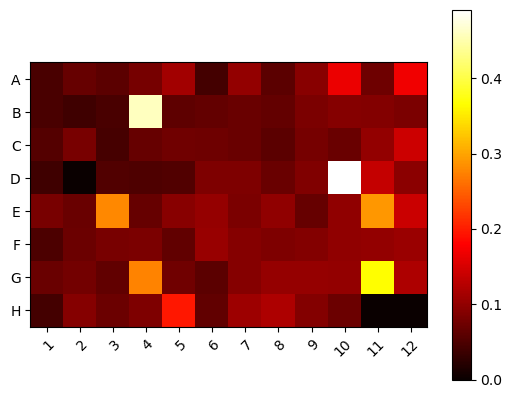

In [4]:
#make heatmap of data2
CV_dataframe, CVs = get_cv_df(data4, 37, 11)
fig, ax = heatmap_from_CVs(CVs)

In [5]:
#make CV_dataframe for all data and concatenate them, then make heatmap
CV_dataframe1, CVs1 = get_cv_df(data1, 37, 11)
CV_dataframe2, CVs2 = get_cv_df(data2,  37, 11)
CV_dataframe3, CVs3 = get_cv_df(data3,  37, 11)
CV_dataframe4, CVs4 = get_cv_df(data4,  37, 11)
CV_dataframe5, CVs5 = get_cv_df(data5, 37, 11)
CV_df = pd.concat([CV_dataframe2, CV_dataframe3, CV_dataframe4, CV_dataframe5])
CV__df = CV_df.reset_index(drop=True)
#groupby position and take mean of CVs
CV_df = CV__df.groupby("Position").mean()
CV_df = CV_df.reset_index()
#sort by cv
CV_df = CV_df.sort_values(by="CV")

In [6]:
#import /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes/filtering_results.csv separator \
filtering_results = pd.read_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes/filtering_results.csv", sep="\t")
#groupby Strain and take mean %flocc
filtering_results = filtering_results.groupby("Strain").mean()
#sort by %flocc
filtering_results.sort_values(by="%flocc")

,ODf,ODr,ODf+ODr,%flocc,Rep
Strain,,,,,
R33,6.906667,0.146667,7.053333,2.075254,2.00
R30,6.600000,0.143333,6.743333,2.109127,2.00
R13,6.600000,0.146667,6.746667,2.179931,2.00
R26,6.533333,0.153333,6.686667,2.294283,2.00
R41,6.133333,0.143333,6.276667,2.295753,2.00
R16,7.466667,0.183333,7.650000,2.378830,2.00
R25,6.800000,0.170000,6.970000,2.431318,2.00
R20,7.200000,0.186667,7.386667,2.529943,2.00
R46,5.933333,0.153333,6.086667,2.570907,2.00


In [7]:
#import /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes/strains.csv
strains = pd.read_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes/strains.csv",header=None)
#RENAME COLUMNS 1-12, INDICES A-H
strains = strains.rename(columns={0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7", 7:"8", 8:"9", 9:"10", 10:"11", 11:"12"})
strains = strains.rename(index={0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H"})
strains


,1,2,3,4,5,6,7,8,9,10,11,12
A,JB50,JB22,JB869,JB760,JB1315,JB759,JB22,JB869,JB760,JB1315,JB759,JB50
B,JB759,JB759,R1,R7,R13,R19,R25,R31,R37,R43,R49,JB759
C,JB50,JB50,R2,R8,R14,R20,R26,R32,R38,R44,R50,JB50
D,JB759,ø,R3,R9,R15,R21,R27,R33,R39,R45,R51,JB759
E,JB50,JB759,R4,R10,R16,R22,R28,R34,R40,R46,R52,JB50
F,JB759,JB869,R5,R11,R17,R23,R29,R35,R41,R47,R53,JB759
G,JB50,JB22,R6,R12,R18,R24,R30,R36,R42,R48,R54,JB50
H,JB759,JB22,JB869,JB760,JB1315,JB759,JB22,JB869,JB760,JB1315,JB759,JB759


In [8]:
#loop through position in CV_df and get the strain from strains
strain_list = []
for i in CV_df["Position"]:
    #get row and column by splitting the position as the first character being the index and the rest being the column
    row = i[0]
    column = i[1:]
    #get the strain from strains
    strain = strains.loc[row, column]
    strain_list.append(strain)
#add the strain list to CV_df
CV_df["Strain"] = strain_list
#merge CV_df with filtering_results on Strain
CV_df_final_seg = CV_df.merge(filtering_results, on="Strain")
#remove any strain that starts with JB
CV_df_final_seg = CV_df_final_seg[~CV_df_final_seg["Strain"].str.startswith("JB")]



In [9]:
#remove entry at D2 in CV_df_final_seg
CV_df_final_seg = CV_df_final_seg[CV_df_final_seg["Position"] != "D2"]


Text(0.05, 0.9, 'p-value: 4.59e-15')

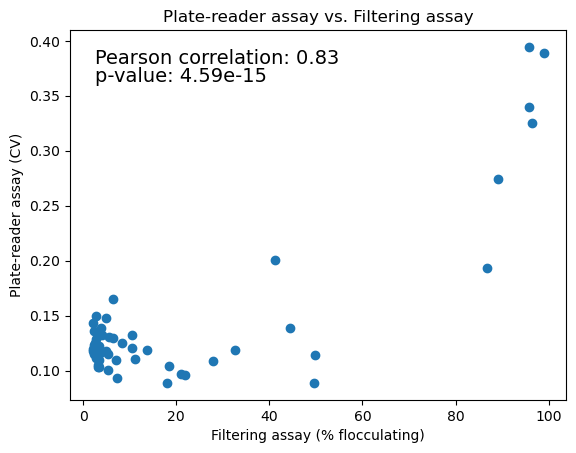

In [27]:
#plot CV vs %flocc
import scipy.stats as st
fig, ax = plt.subplots()
ax.scatter(CV_df_final_seg["%flocc"],CV_df_final_seg["CV"])
ax.set_xlabel("Filtering assay (% flocculating)")
ax.set_ylabel("Plate-reader assay (CV)")

#make it pretty and put pearson correlation on the plot
ax.set_title("Plate-reader assay vs. Filtering assay")
#print pearson correlation
ax.text(0.05, 0.95, "Pearson correlation: " + str(round(st.pearsonr(CV_df_final_seg["%flocc"],CV_df_final_seg["CV"])[0], 2)), transform=ax.transAxes, fontsize=14, verticalalignment='top')
#print p-value
ax.text(0.05, 0.9, "p-value: " + str(round(st.pearsonr(CV_df_final_seg["%flocc"],CV_df_final_seg["CV"])[1], 17)), transform=ax.transAxes, fontsize=14, verticalalignment='top')




Text(0, 0.5, 'CV')

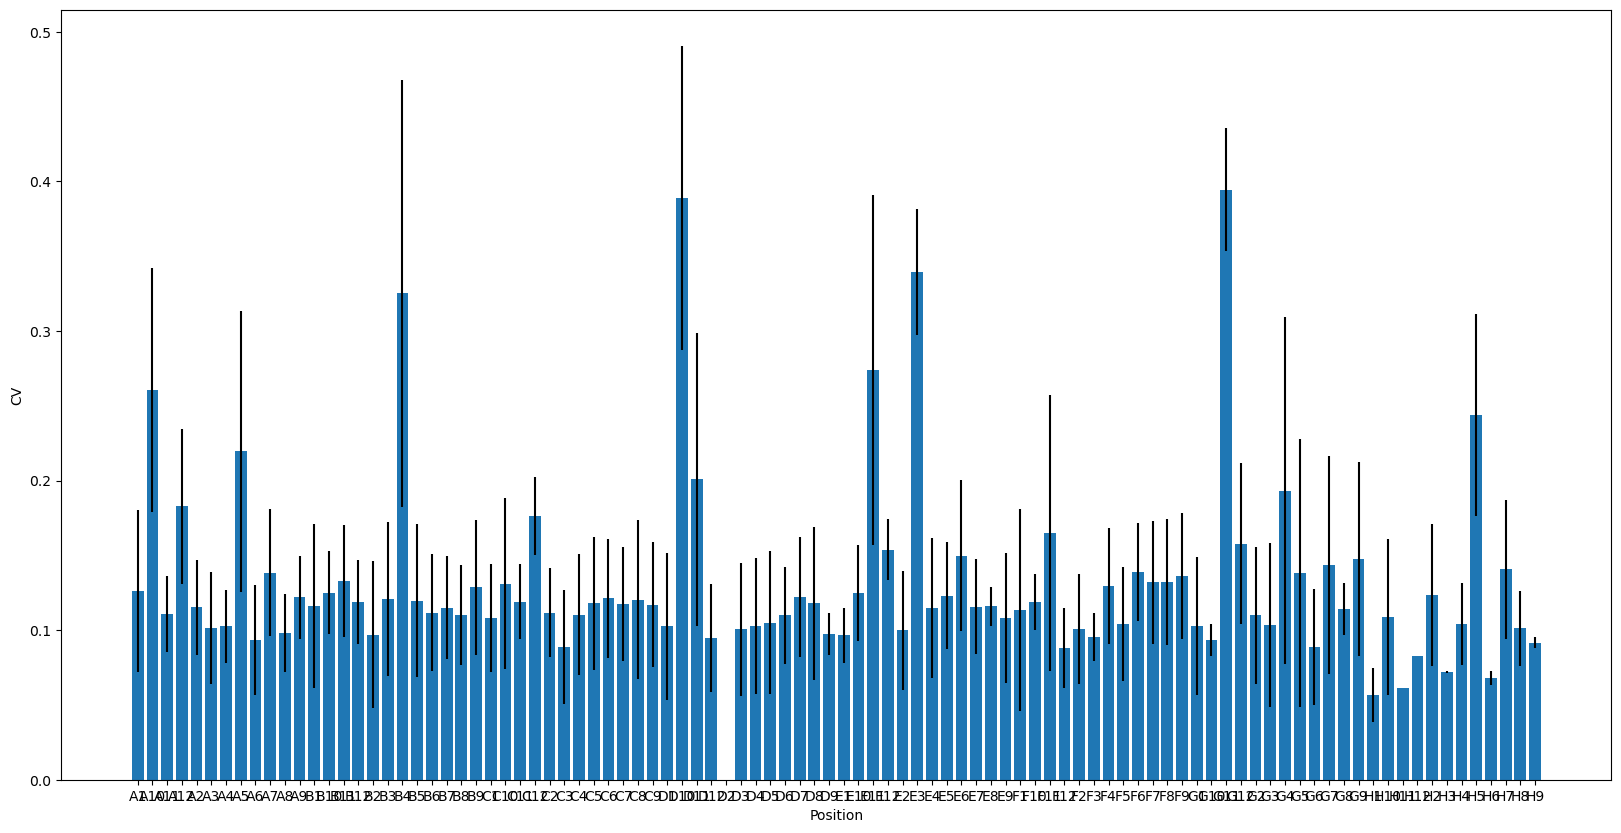

In [11]:
#make barchart from CV__df with error bars
#wide plot
fig, ax = plt.subplots(figsize=(20,10))
#create a new df with means and sd
CV_df_mean = CV__df.groupby("Position").mean()
CV_df_mean = CV_df_mean.reset_index()
CV_df_sd = CV__df.groupby("Position").std()
CV_df_sd = CV_df_sd.reset_index()
#merge the two dfs
CV_df_mean_sd = CV_df_mean.merge(CV_df_sd, on="Position")
#plot means with error bars
ax.bar(CV_df_mean_sd["Position"], CV_df_mean_sd["CV_x"], yerr=CV_df_mean_sd["CV_y"])
ax.set_xlabel("Position")
ax.set_ylabel("CV")




# Repeat for wild isolates

In [12]:
strains_wi = pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/final wild strain map.xlsx",header=None)

#RENAME COLUMNS 1-12, INDICES A-H
strains_wi = strains_wi.rename(columns={0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7", 7:"8", 8:"9", 9:"10", 10:"11", 11:"12"})
strains_wi = strains_wi.rename(index={0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H"})
strains_wi 


,1,2,3,4,5,6,7,8,9,10,11,12
A,JB50,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB759,JB50
B,JB759,JB50,JB1110,JB1117,JB1154,JB1171,JB1174,JB1180,JB1197,JB1205,JB1206,JB759
C,JB50,JB759,JB1207,JB22,JB4,JB758,JB760,JB762,JB837,JB838,JB840,JB50
D,JB759,JB841,JB842,JB845,JB846,JB848,JB852,JB853,JB854,JB858,JB862,JB759
E,JB50,JB864,JB869,JB870,JB871,JB872,JB873,JB874,JB875,JB878,JB879,JB50
F,JB759,JB884,JB899,JB900,JB902,JB910,JB913,JB914,JB916,JB917,JB918,JB759
G,JB50,JB929,JB930,JB931,JB934,JB938,JB939,JB942,JB943,JB953,EMPTY,JB50
H,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB759,JB50,JB759


In [13]:
#make a dataframe with two columns, strain and pos, where pos is things like A1, B2, etc.
#make a list of positions
pos_list = []
for i in range(1,13):
      for j in "ABCDEFGH":
            pos = j+str(i)
            pos_list.append(pos)
#make a list of strains
strain_list = []
for i in pos_list:
      row = i[0]
      column = i[1:]
      strain = strains_wi.loc[row, column]
      strain_list.append(strain)
#make a dataframe with the two lists
strain_pos = pd.DataFrame({"Strain":strain_list, "Position":pos_list})

In [21]:
#make CV_dataframe for all data and concatenate them, then make heatmap
CV_dataframe1, CVs1 = get_cv_df(data_wi, 82, 10)
CV_dataframe2, CVs2 = get_cv_df(data_wi2, 82, 10)
CV_dataframe3, CVs3 = get_cv_df(data_wi3,  82, 11)
CV_dataframe4, CVs4 = get_cv_df(data_wi4, 82, 11)
CV_dataframe5, CVs5 = get_cv_df(data_wi5,  82, 11)
CV_df = pd.concat([CV_dataframe3, CV_dataframe4, CV_dataframe5])
CV_df = CV_df.reset_index(drop=True)

#remove values with CV < 0.001 or Cv >1
CV_df = CV_df[CV_df["CV"] > 0.001]
CV_df = CV_df[CV_df["CV"] < 1]
#merge CV_df with strain_pos
CV_df = CV_df.merge(strain_pos, on="Position")

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_71588/4233815962.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(CV_df_mean_sd["Strain"], rotation=90)


[Text(0, 0, 'JB1110'),
 Text(1, 0, 'JB1117'),
 Text(2, 0, 'JB1154'),
 Text(3, 0, 'JB1171'),
 Text(4, 0, 'JB1174'),
 Text(5, 0, 'JB1180'),
 Text(6, 0, 'JB1197'),
 Text(7, 0, 'JB1205'),
 Text(8, 0, 'JB1206'),
 Text(9, 0, 'JB1207'),
 Text(10, 0, 'JB22'),
 Text(11, 0, 'JB4'),
 Text(12, 0, 'JB50'),
 Text(13, 0, 'JB758'),
 Text(14, 0, 'JB759'),
 Text(15, 0, 'JB760'),
 Text(16, 0, 'JB762'),
 Text(17, 0, 'JB837'),
 Text(18, 0, 'JB838'),
 Text(19, 0, 'JB840'),
 Text(20, 0, 'JB842'),
 Text(21, 0, 'JB845'),
 Text(22, 0, 'JB846'),
 Text(23, 0, 'JB848'),
 Text(24, 0, 'JB852'),
 Text(25, 0, 'JB853'),
 Text(26, 0, 'JB854'),
 Text(27, 0, 'JB858'),
 Text(28, 0, 'JB862'),
 Text(29, 0, 'JB864'),
 Text(30, 0, 'JB869'),
 Text(31, 0, 'JB870'),
 Text(32, 0, 'JB871'),
 Text(33, 0, 'JB872'),
 Text(34, 0, 'JB873'),
 Text(35, 0, 'JB874'),
 Text(36, 0, 'JB875'),
 Text(37, 0, 'JB878'),
 Text(38, 0, 'JB879'),
 Text(39, 0, 'JB884'),
 Text(40, 0, 'JB899'),
 Text(41, 0, 'JB900'),
 Text(42, 0, 'JB902'),
 Text(43, 0, 'J

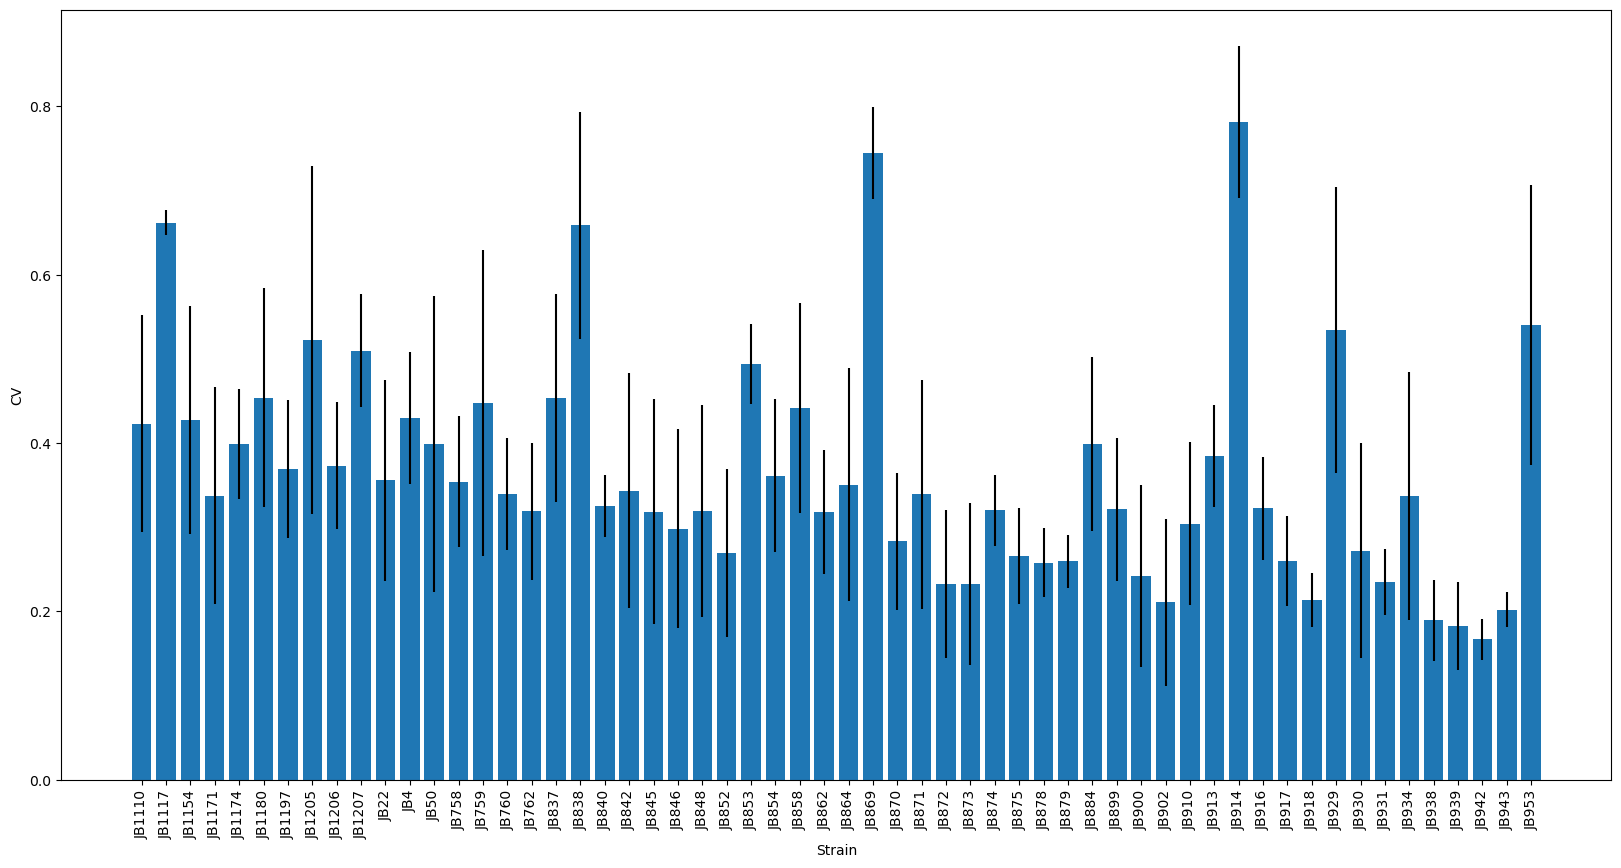

In [22]:
#make barchart from CV__df with error bars
#wide plot
fig, ax = plt.subplots(figsize=(20,10))
#create a new df with means and sd
CV_df_mean = CV_df.groupby("Strain").mean()
CV_df_mean = CV_df_mean.reset_index()
CV_df_sd = CV_df.groupby("Strain").std()
CV_df_sd = CV_df_sd.reset_index()
#merge the two dfs
CV_df_mean_sd = CV_df_mean.merge(CV_df_sd, on="Strain")
#plot means with error bars
ax.bar(CV_df_mean_sd["Strain"], CV_df_mean_sd["CV_x"], yerr=CV_df_mean_sd["CV_y"])
ax.set_xlabel("Strain")
ax.set_ylabel("CV")
ax.set_xticklabels(CV_df_mean_sd["Strain"], rotation=90)

In [ ]:
#CV_df_mean_sd merge with strain pos

#rename CV_x to mean and CV_y to sem
CV_df_mean_sd = CV_df_mean_sd.rename(columns={"CV_x":"Mean", "CV_y":"SEM"})
#save as csv 
CV_df_mean_sd.to_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes/plate_reader_wild_isolates_results.csv")

# Rep for wild isolates YES

In [16]:
CV_dataframe1, CVs1 = get_cv_df(data_wi_yes_1,  82, 11)
CV_dataframe2, CVs2 = get_cv_df(data_wi_yes_2, 82, 11)
CV_dataframe3, CVs3 = get_cv_df(data_wi_yes_3,  82, 11)
CV_df = pd.concat([CV_dataframe1, CV_dataframe2, CV_dataframe3])
CV_df = CV_df.reset_index(drop=True)

#remove values with CV < 0.001 or Cv >1
CV_df = CV_df[CV_df["CV"] > 0.001]
CV_df = CV_df[CV_df["CV"] < 1]
#merge CV_df with strain_pos
CV_df = CV_df.merge(strain_pos, on="Position")

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_71588/4233815962.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(CV_df_mean_sd["Strain"], rotation=90)


[Text(0, 0, 'JB1110'),
 Text(1, 0, 'JB1117'),
 Text(2, 0, 'JB1154'),
 Text(3, 0, 'JB1171'),
 Text(4, 0, 'JB1174'),
 Text(5, 0, 'JB1180'),
 Text(6, 0, 'JB1197'),
 Text(7, 0, 'JB1205'),
 Text(8, 0, 'JB1206'),
 Text(9, 0, 'JB1207'),
 Text(10, 0, 'JB22'),
 Text(11, 0, 'JB4'),
 Text(12, 0, 'JB50'),
 Text(13, 0, 'JB758'),
 Text(14, 0, 'JB759'),
 Text(15, 0, 'JB760'),
 Text(16, 0, 'JB762'),
 Text(17, 0, 'JB837'),
 Text(18, 0, 'JB838'),
 Text(19, 0, 'JB840'),
 Text(20, 0, 'JB842'),
 Text(21, 0, 'JB845'),
 Text(22, 0, 'JB846'),
 Text(23, 0, 'JB848'),
 Text(24, 0, 'JB852'),
 Text(25, 0, 'JB853'),
 Text(26, 0, 'JB854'),
 Text(27, 0, 'JB858'),
 Text(28, 0, 'JB862'),
 Text(29, 0, 'JB864'),
 Text(30, 0, 'JB869'),
 Text(31, 0, 'JB870'),
 Text(32, 0, 'JB871'),
 Text(33, 0, 'JB872'),
 Text(34, 0, 'JB873'),
 Text(35, 0, 'JB874'),
 Text(36, 0, 'JB875'),
 Text(37, 0, 'JB878'),
 Text(38, 0, 'JB879'),
 Text(39, 0, 'JB884'),
 Text(40, 0, 'JB899'),
 Text(41, 0, 'JB900'),
 Text(42, 0, 'JB902'),
 Text(43, 0, 'J

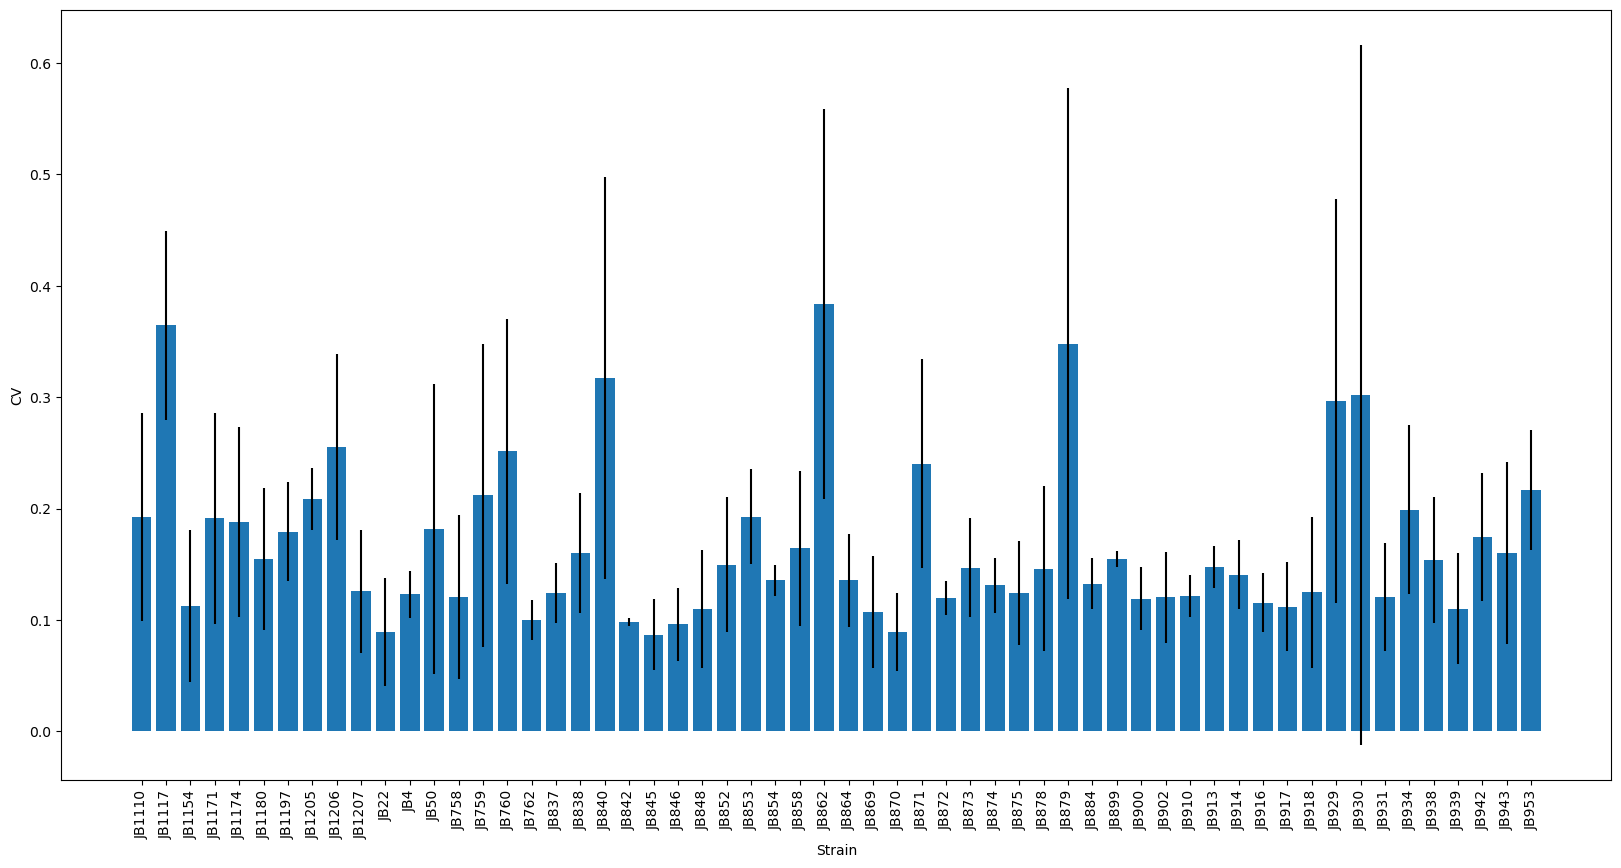

In [20]:
#make barchart from CV__df with error bars
#wide plot
fig, ax = plt.subplots(figsize=(20,10))
#create a new df with means and sd
CV_df_mean = CV_df.groupby("Strain").mean()
CV_df_mean = CV_df_mean.reset_index()
CV_df_sd = CV_df.groupby("Strain").std()
CV_df_sd = CV_df_sd.reset_index()
#merge the two dfs
CV_df_mean_sd = CV_df_mean.merge(CV_df_sd, on="Strain")
#plot means with error bars
ax.bar(CV_df_mean_sd["Strain"], CV_df_mean_sd["CV_x"], yerr=CV_df_mean_sd["CV_y"])
ax.set_xlabel("Strain")
ax.set_ylabel("CV")
ax.set_xticklabels(CV_df_mean_sd["Strain"], rotation=90)